In [2]:
pip install scikit-learn pandas numpy opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import cv2 as cv
import csv
import os
import re
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import joblib

In [5]:
filename = 'colors.csv'
fields = []
rows = []

def generate_colors():
    # RED (two hue regions)
    for hue in list(range(0, 11, 2)) + list(range(170, 181, 2)):
        for sat in range(150, 256, 20):
            for val in range(150, 256, 20):
                rows.append({'h': hue, 's': sat, 'v': val, 'target': 'Red'})
    
    # ORANGE
    for hue in range(10, 26, 2):
        for sat in range(140, 256, 20):
            for val in range(140, 256, 20):
                rows.append({'h': hue, 's': sat, 'v': val, 'target': 'Orange'})
    
    # YELLOW
    for hue in range(25, 39, 2):
        for sat in range(150, 256, 20):
            for val in range(150, 256, 20):
                rows.append({'h': hue, 's': sat, 'v': val, 'target': 'Yellow'})
    
    # GREEN
    for hue in range(50, 86, 2):
        for sat in range(100, 256, 20):
            for val in range(100, 256, 20):
                rows.append({'h': hue, 's': sat, 'v': val, 'target': 'Green'})
    
    # BLUE
    for hue in range(100, 131, 2):
        for sat in range(150, 256, 20):
            for val in range(100, 256, 20):
                rows.append({'h': hue, 's': sat, 'v': val, 'target': 'Blue'})
    
    # WHITE (low saturation, high brightness)
    for hue in range(0, 181, 20):
        for sat in range(0, 31, 10):
            for val in range(200, 256, 10):
                rows.append({'h': hue, 's': sat, 'v': val, 'target': 'White'})

generate_colors()

In [6]:
import os
import cv2 as cv
import numpy as np

def extract_tile_hsv(image, row, col, grid_size=3, blur=True):
    height, width = image.shape[:2]
    cell_h = height // grid_size
    cell_w = width // grid_size

    x1 = col * cell_w
    y1 = row * cell_h
    x2 = x1 + cell_w
    y2 = y1 + cell_h

    tile = image[y1:y2, x1:x2]

    if blur:
        tile = cv.GaussianBlur(tile, (5, 5), 0)

    hsv_tile = cv.cvtColor(tile, cv.COLOR_BGR2HSV)

    mask = (hsv_tile[..., 1] > 50) & (hsv_tile[..., 2] > 50)
    pixels = hsv_tile[mask]

    if pixels.size > 0:
        mean_hsv = np.mean(pixels, axis=0)
    else:
        mean_hsv = np.mean(hsv_tile.reshape(-1, 3), axis=0)

    return mean_hsv.astype(np.uint8)


def extract_face_tiles(image, label):
    tiles = []
    for row in range(3):
        for col in range(3):
            tile_hsv = extract_tile_hsv(image, row, col)
            tiles.append({
                'h': tile_hsv[0],
                's': tile_hsv[1],
                'v': tile_hsv[2],
                'target': label
            })
    return tiles

In [10]:
folder_path = "real_images"
all_tiles = []

def get_label_from_filename(filename):
    match = re.match(r"([a-zA-Z]+)", filename)
    if match:
        return match.group(1).capitalize()
    return "Unknown"

for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        label = get_label_from_filename(filename)
        image_path = os.path.join(folder_path, filename)
        image = cv.imread(image_path)
        if image is not None:
            tiles = extract_face_tiles(image, label)
            all_tiles.extend(tiles)
    

print("Total samples:", len(all_tiles))
print(all_tiles[0])

Total samples: 162
{'h': 14, 's': 83, 'v': 156, 'target': 'Red'}


In [11]:
with open ('colors.csv', 'a', newline ='') as csvfile:
    fields = ['h','s','v','target']
    writer = csv.DictWriter(csvfile, fieldnames=fields)
    writer.writeheader()
    writer.writerows(rows)
    # writer.writerows(all_tiles)

In [17]:
color_df = pd.read_csv('colors.csv')
# Step 2: Remove rows where any of h/s/v are not numeric (like 'h')
color_df = color_df[pd.to_numeric(color_df["h"], errors="coerce").notna()]
color_df = color_df[pd.to_numeric(color_df["s"], errors="coerce").notna()]
color_df = color_df[pd.to_numeric(color_df["v"], errors="coerce").notna()]

# Step 3: Convert all columns to the correct data types
color_df["h"] = color_df["h"].astype(int)
color_df["s"] = color_df["s"].astype(int)
color_df["v"] = color_df["v"].astype(int)

# Step 4: Ready for training
X = color_df[["h", "s", "v"]]
y = color_df["target"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# baseline
dummy = DummyClassifier(strategy='most_frequent')

# hyperparamter optimization
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
}
rf = RandomForestClassifier(max_depth=None, n_estimators=150, min_samples_leaf=1, random_state=123)
# grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid.fit(x_train, y_train)
# print("Best parameters:", grid.best_params_)
# print("Best accuracy:", grid.best_score_)

rf.fit(x_train, y_train)
dummy.fit(x_train, y_train)
acc = dummy.score(x_test, y_test)
print(f'accuracy: {acc:.2f}')
print("RF Accuracy:", rf.score(x_test, y_test))

accuracy: 0.36
RF Accuracy: 0.997907949790795


In [18]:
joblib.dump(rf, 'color_classifier.pkl')

['color_classifier.pkl']

              precision    recall  f1-score   support

        Blue       1.00      0.99      1.00       147
       Green       1.00      1.00      1.00       226
      Orange       0.97      0.99      0.98        68
         Red       0.99      0.98      0.99       112
       White       1.00      1.00      1.00        55
      Yellow       1.00      1.00      1.00        51

    accuracy                           0.99       659
   macro avg       0.99      0.99      0.99       659
weighted avg       0.99      0.99      0.99       659



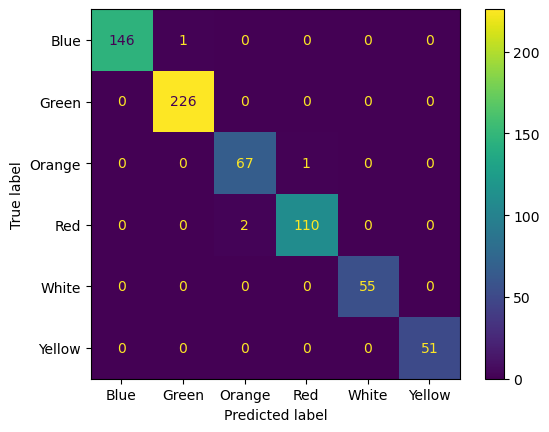

In [30]:
# f1, pred, recall, confusion matrix
y_pred = rf.predict(x_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [36]:
random = [[10, 75,95]]
pred_color = rf.predict(random)
print('pred:', pred_color[0])

pred: Red


/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
